<a href="https://colab.research.google.com/github/hwangsaeyeon/DepressionChatbot/blob/main/kobert%EC%9D%98%EB%8F%84%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Libraries

In [ ]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292701 sha256=48eae7c1ce1b7804b087f4a454d7d315e092750f7ada5b34ca31fc903aa2e5d6
  Stored in directory: /root/.cache/pip/wheels/2d/cc/dc/7ec84dced25f738b8be400101abb67e4b50c905090a51017e4
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, ht

In [ ]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-uyrj3sfq/kobert-tokenizer_40450599f5bc4b8a8c9255f6390dabc3
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-uyrj3sfq/kobert-tokenizer_40450599f5bc4b8a8c9255f6390dabc3
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=fe0bda0300adb03b540b5b6df829dfdcd82ee91d79f954ca7df5af7f446bcd88
  Stored in directory: /tmp/pip-ephem-wheel-cache-z0k6ux3y/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel

#GPU 사용 시
device = torch.device("cuda:0")

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


##Load

In [ ]:
import urllib.request
import pandas as pd
Chatbot_Data = pd.read_csv("/content/emotional_training_merge.csv",index_col=0,)
Chatbot_Data.head()
Chatbot_Data_val = pd.read_csv("/content/emotional_validation_merge.csv",index_col=0)
Chatbot_Data_val.head()

FileNotFoundError: ignored

In [ ]:
faq['hs'] = faq.body
faq['label'] = 2

In [ ]:
#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split
faq_train, faq_test = train_test_split(faq.loc[:,['body','label','answer']], test_size=0.2, shuffle=True, random_state=34)
faq_train['hs'] = faq_train['body']
faq_test['hs'] = faq_test['body']
faq_train['ss'] = faq_train['answer']
faq_test['ss'] = faq_test['answer']

In [ ]:
Chatbot_Data = Chatbot_Data.dropna(axis=0)
Chatbot_Data_val = Chatbot_Data_val.dropna(axis=0)

In [ ]:
worry = Chatbot_Data[Chatbot_Data.emotion=='불안']
worry_val = Chatbot_Data_val[Chatbot_Data_val.emotion=='불안']

anger = Chatbot_Data[Chatbot_Data.emotion=='분노']
anger_val = Chatbot_Data_val[Chatbot_Data_val.emotion=='분노']

wound = Chatbot_Data[Chatbot_Data.emotion=='상처']
wound_val = Chatbot_Data_val[Chatbot_Data_val.emotion=='상처']

embar = Chatbot_Data[Chatbot_Data.emotion=='당황']
embar_val = Chatbot_Data_val[Chatbot_Data_val.emotion=='당황']

sadne = Chatbot_Data[Chatbot_Data.emotion=='슬픔']
sadne_val = Chatbot_Data_val[Chatbot_Data_val.emotion=='슬픔']

joy = Chatbot_Data[Chatbot_Data.emotion=='기쁨']
joy_val = Chatbot_Data_val[Chatbot_Data_val.emotion=='기쁨']

In [ ]:
worry['label'] = 1
anger['label'] = 1
wound['label'] = 1
embar['label'] = 1
sadne['label'] = 1
joy['label'] = 0

worry_val['label'] = 1
anger_val['label'] = 1
wound_val['label'] = 1
embar_val['label'] = 1
sadne_val['label'] = 1
joy_val['label'] = 0

In [ ]:
#0: joy 1: depressed
data_depressed = pd.concat([joy,worry, anger, wound, embar, sadne,faq_train],ignore_index=True).loc[:,['hs','label']]
data_depressed_val = pd.concat([joy_val,worry_val, anger_val, wound_val, embar_val, sadne_val,faq_test],ignore_index=True).loc[:,['hs','label']]

In [ ]:
train_save = pd.concat([joy,worry, anger, wound, embar, sadne,faq_train],ignore_index=True).loc[:,['hs','ss','label']]
test_save = pd.concat([joy_val,worry_val, anger_val, wound_val, embar_val, sadne_val,faq_test],ignore_index=True).loc[:,['hs','ss','label']]

In [ ]:
train_save.to_csv('train_save.csv')
test_save.to_csv('test_save.csv')

In [ ]:
length = []
for i in data_depressed.hs :
    length.append(len(i))
print(max(length))
print(min(length))
print(sum(length)/len(length))


307
16
99.70720058780309


Text(0.5, 1.0, 'Corpus Length of Emotional Conversation with Hidoc Dataset')

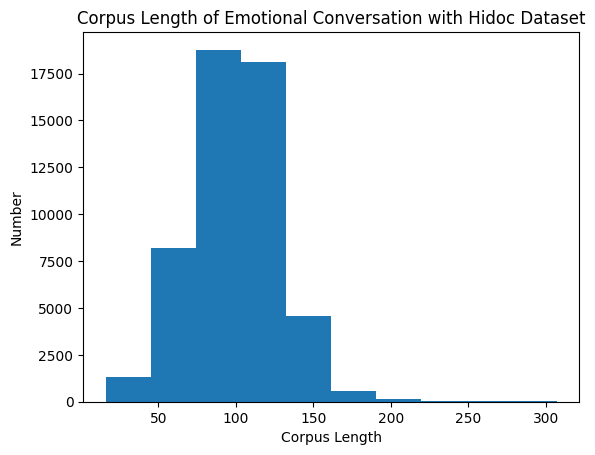

In [ ]:
import matplotlib.pyplot as plt
plt.hist(length,)
plt.xlabel('Corpus Length')
plt.ylabel('Number')
plt.title('Corpus Length of Emotional Conversation with Hidoc Dataset')

In [ ]:
data_depressed

,hs,label
0,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.더 좋은 회사가 기다리고 있을지...,0
1,요즘 직장생활이 너무 편하고 좋은 것 같아!우리 회사는 복지가 정말 좋아! 내가 곧...,0
2,취업해야 할 나이인데 취업하고 싶지가 않아.아직 조금 더 놀고 싶은 마음이 커. 인...,0
3,우리 회사는 정말 사내 분위기가 좋아.즐거운 일이 매일 생길 거 같은 기분이야. 내...,0
4,오늘 내가 다니는 회사가 참 좋은 직장이라는 생각이 들었어.회사에서 내가 제안한 프...,0
...,...,...
51713,아이가 어렸을 때 맞벌이하느라 제대로 돌봐주지 못했습니다. 늘 의기소침해 있고 짜증...,2
51714,우울증으로 약물치료를 받은 지 한달 정도 되었어요. 의사 선생님은 저더러 좋아졌다고...,2
51715,뇌졸중 후 우울증에 걸린 것 같습니다. 어떻게 해야 할까요?,2
51716,현재 우울증때문에 항우울제를 먹고 있는데요. 이거 앞으로 복용 중단 못하게 되나요?...,2


In [ ]:
data_depressed.label.value_counts()

1    45504
0     6126
2       88
Name: label, dtype: int64

In [ ]:
data_depressed_val.label.value_counts()

1    5428
0    1213
2      22
Name: label, dtype: int64

##Kobert

In [ ]:
data_depressed = pd.read_csv('train_save.csv',index_col=0)
data_depressed_val = pd.read_csv('test_save.csv',index_col=0)

In [ ]:
data_depressed = data_depressed.loc[:,['hs','label']]
data_depressed_val = data_depressed_val.loc[:,['hs','label']]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
hidoc = pd.read_csv('/content/faq_data.csv',index_col=0)
hidoc['label'] = 2
hidoc = hidoc.drop(['title'],axis=1)
hidoc.columns = ['hs','ss','label']
hidoc = hidoc.loc[:,['hs','label']]
hidoc_train = hidoc[:100]
hidoc_test = hidoc[100:]

In [ ]:
one = data_depressed[data_depressed.label==1].sample(n=100,replace=False)
zero = data_depressed[data_depressed.label==0].sample(n=100,replace=False)
data = pd.concat([zero,one])
data_depressed = pd.concat([data, hidoc_train])
data_depressed

,hs,label
3624,결혼 후 아내는 많이 바뀌었어. 나는 그게 너무 기뻐.아내는 남자들과 연락을 다 끊...,0
5461,자료정리가 완벽하게 된 거 같아 완전 뿌듯해!앞으로도 완벽하게 자료정리를 잘해서 뿌...,0
4558,내가 제안한 기획서로 광고가 만들어진대!내게 이런 일이 오다니 정말 행복해.맞아. ...,0
5194,내가 간호사로 일하고 있을 걸 떠올리면 흥분되고 마음이 벅차.간호사는 나랑 잘 맞는...,0
1840,오늘 건강 검진이라서 아내랑 병원에 다녀왔는데 다행히 별문제 없다네.나도 그렇고 아...,0
...,...,...
95,주부 우울증은 어떤 경우에 발병합니까??,2
96,저의 괴로움을 어느 누구도 이해해주지 못합니다. 병원에 가서도 마찬가지일 것 같은데...,2
97,저는 우울증 아내를 둔 40대 남자입니다. 우울증은 자살위험이 높다는데 걱정됩니다....,2
98,저는 26세로 2년 전 결혼한 주부인데 병원에서 우울증의 진단을 받고 약을 복용하고...,2


In [ ]:
one = data_depressed_val[data_depressed_val.label==1].sample(n=10,replace=False)
zero = data_depressed_val[data_depressed_val.label==0].sample(n=10,replace=False)
data = pd.concat([zero,one])
data_depressed_val = pd.concat([data,hidoc_test])
data_depressed_val

,hs,label
1119,내가 사둔 땅값이 올라 기뻐 이제 나도 남들에게 많이 베풀고 살아야겠다는 생각이 들...,0
523,오늘 하루 열심히 일해서 퇴근길에 너무 뿌듯해.앞으로도 이렇게 열심히 하고 싶어.급...,0
383,아빠가 운전을 하다가 사고가 날 뻔했어. 사고가 나지 않아서 다행이야.아빠가 운전 ...,0
766,자식들도 결혼했고 나는 이제 돈 쓸 일이 거의 없어.응. 결혼했을 때부터 주식을 조...,0
557,우리 아들이 학교 다닐 때 매일 친구들을 집으로 데리고 와서 놀았어.내 자식 같아서...,0
367,다른 건 차치하고 자식들이 내 건강 걱정은 할 필요가 없어서 좋아.응. 내가 건강 ...,0
574,내 나이가 적지 않은 나이인데 좋은 제안이 들어와서 이직하게 된 것에 대해 감사해....,0
1063,대인관계가 만족스러워.요즘 친구들이랑 사이가 좋아.,0
274,매일 병원 밥만 먹다가 가족들과 맛있는 집밥을 먹으니 너무 행복해.다시 병원 신세를...,0
93,집중해서 할 수 있는 공부법을 발견해서 너무 만족스러워.이 공부 법이라면 시험에서 ...,0


In [ ]:
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer

        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')


In [ ]:
# Setting parameters
max_len = 512
batch_size = 4
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/우울증챗봇/train.csv',index_col=0)
test = pd.read_csv('/content/drive/MyDrive/우울증챗봇/test.csv',index_col=0)

In [ ]:
train = train.dropna()
test = test.dropna()
train = train.drop(['ss'],axis=1)
test = test.drop(['ss'],axis=1)

In [ ]:
# ★ Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

#tok = tokenizer.tokenize
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

data_train = BERTDataset(train.values, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(test.values, 0, 1, tokenizer, vocab, max_len, True, False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)


In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
train_history=[]
test_history=[]
loss_history=[]
label_history = []
out_history = []
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            #train_history.append(train_acc / (batch_id+1))
            #loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    train_history.append(train_acc / (batch_id+1))



<ipython-input-29-8ce35f5cd7b7>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/1425 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.5922003984451294 train acc 0.25
epoch 1 batch id 201 loss 0.41349464654922485 train acc 0.5833333333333334
epoch 1 batch id 401 loss 0.6981052160263062 train acc 0.7450124688279302
epoch 1 batch id 601 loss 0.007057313807308674 train acc 0.7957570715474209
epoch 1 batch id 801 loss 0.005129209719598293 train acc 0.8289637952559301
epoch 1 batch id 1001 loss 0.0010712717194110155 train acc 0.8508991008991009
epoch 1 batch id 1201 loss 0.001934249885380268 train acc 0.8680266444629475
epoch 1 batch id 1401 loss 0.0009984271600842476 train acc 0.8802640970735189
epoch 1 train acc 0.8812280701754386


  0%|          | 0/1425 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.0764790773391724 train acc 0.75
epoch 2 batch id 201 loss 1.172240138053894 train acc 0.9440298507462687
epoch 2 batch id 401 loss 0.004858813248574734 train acc 0.9457605985037406
epoch 2 batch id 601 loss 0.0018464893801137805 train acc 0.9463394342762064
epoch 2 batch id 801 loss 0.004010562784969807 train acc 0.9463171036204744
epoch 2 batch id 1001 loss 0.0015209104167297482 train acc 0.9473026973026973
epoch 2 batch id 1201 loss 0.002267212141305208 train acc 0.9494171523730225
epoch 2 batch id 1401 loss 1.3700523376464844 train acc 0.9518201284796574
epoch 2 train acc 0.9519298245614035


  0%|          | 0/1425 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.011656670831143856 train acc 1.0
epoch 3 batch id 201 loss 0.0023861706722527742 train acc 0.9788557213930348
epoch 3 batch id 401 loss 0.002404032973572612 train acc 0.9719451371571073
epoch 3 batch id 601 loss 0.002978605218231678 train acc 0.9746256239600666
epoch 3 batch id 801 loss 0.0009895277908071876 train acc 0.9753433208489388
epoch 3 batch id 1001 loss 0.0009245031978935003 train acc 0.9755244755244755
epoch 3 batch id 1201 loss 0.0064532700926065445 train acc 0.9760616153205662
epoch 3 batch id 1401 loss 0.003515353426337242 train acc 0.9759100642398287
epoch 3 train acc 0.976140350877193


  0%|          | 0/1425 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.0010033078724518418 train acc 1.0
epoch 4 batch id 201 loss 0.00027368494193069637 train acc 0.9925373134328358
epoch 4 batch id 401 loss 0.0007691149949096143 train acc 0.9894014962593516
epoch 4 batch id 601 loss 0.00011937832459807396 train acc 0.9866888519134775
epoch 4 batch id 801 loss 0.0005458681844174862 train acc 0.9875156054931336
epoch 4 batch id 1001 loss 0.0003524082712829113 train acc 0.9885114885114885
epoch 4 batch id 1201 loss 0.0007096041226759553 train acc 0.988759367194005
epoch 4 batch id 1401 loss 0.0003709137672558427 train acc 0.9887580299785867
epoch 4 train acc 0.9887719298245614


  0%|          | 0/1425 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.0009345746948383749 train acc 1.0
epoch 5 batch id 201 loss 0.00041289685759693384 train acc 0.9925373134328358
epoch 5 batch id 401 loss 0.00024346084683202207 train acc 0.9937655860349127
epoch 5 batch id 601 loss 0.0004670812049880624 train acc 0.9945923460898503
epoch 5 batch id 801 loss 0.00022613367764279246 train acc 0.9943820224719101
epoch 5 batch id 1001 loss 0.00018579416791908443 train acc 0.9942557442557443
epoch 5 batch id 1201 loss 0.0003057519206777215 train acc 0.9941715237302248
epoch 5 batch id 1401 loss 0.0006274519255384803 train acc 0.9946466809421841
epoch 5 train acc 0.9947368421052631


In [ ]:
for e in range(5):
    test_acc = 0.0
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
        #label_history.append(label)
        #out_history.append(out)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))

<ipython-input-30-d4791b99f773>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/162 [00:00<?, ?it/s]

epoch 1 test acc 0.970679012345679


  0%|          | 0/162 [00:00<?, ?it/s]

epoch 2 test acc 0.970679012345679


  0%|          | 0/162 [00:00<?, ?it/s]

epoch 3 test acc 0.970679012345679


  0%|          | 0/162 [00:00<?, ?it/s]

epoch 4 test acc 0.970679012345679


  0%|          | 0/162 [00:00<?, ?it/s]

epoch 5 test acc 0.970679012345679


##New

In [ ]:
import torch, gc
#CUDA_VISIBLE_DEVICES=0
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import torch
torch.save(model, '/content/drive/MyDrive/우울증챗봇/kobert_0619.pt')

In [ ]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("우울하지 않은 감정")
            elif np.argmax(logits) == 1:
                test_eval.append("우울한 감정")
            elif np.argmax(logits) == 2:
                test_eval.append("우울증 관련 구체적 질문")


        print(">> 라벨 : " + test_eval[0])
        return np.argmax(logits)

In [ ]:
model_path = '/content/drive/MyDrive/우울증챗봇/kobert_label3.pt'
model = torch.load(model_path)

In [ ]:
test

,hs,label
0,펀드에 넣어둔 자금이 많이 올랐어.응 아주 신이 나. 생각보다 짧은 기간에 반등했어.,0
1,십 년 사귄 애인과 나는 연락이 잘 안 돼도 서로 믿고 있어.우린 서로를 믿고 있고...,0
2,일찍 자고 일찍 일어났더니 공부할 때 마음이 한결 편안해.생활 패턴이 올바르니까 능...,0
3,음식이 맛있다는 게 새삼 감사한 일이야. 우리 아내는 솜씨가 좋거든.밖에서도 아내 ...,0
4,이번에 내가 로또에 당첨됐어.이제 우리 가정에도 경제적인 여유가 생기겠어.,0
...,...,...
643,인터넷에서 우울증이며 불면증에 효과가있다는 아이도스 mp3 파일을 받았습니다..근래...,2
644,우울증? 불안증?3달전에 여자친구와 헤어졌습니다.1년정도 사귀다가 헤어지게 된 것인...,2
645,중국에서 사업을 2년간 하다 첫사업 실패로 인해 몸과 마음이 큰 상처를 받았습니다....,2
646,27세 여성입니다..4달가까이 불면증 인것같아요.. 우울증도 있는건지..4달전에 너...,2


In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
labels = []
for i in test['hs']:
    sentence = i
    if sentence == "0" :
        break
    label = predict(sentence)
    labels.append(label)
    print("\n")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울한 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울한 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정


>> 라벨 : 우울하지 않은 감정




In [ ]:
data = []
for i in range(len(labels)):
    data.append([test.iloc[i,0],labels[i]])
data = pd.DataFrame(data)
data.columns =['hs','label']
data.to_csv('data_eval.csv')

In [ ]:
all = 0
correct = 0
for i in range(len(labels)):
    all += 1
    if labels[i] == test.iloc[i,1]:
        correct += 1
print(correct/all)

0.9706336939721792


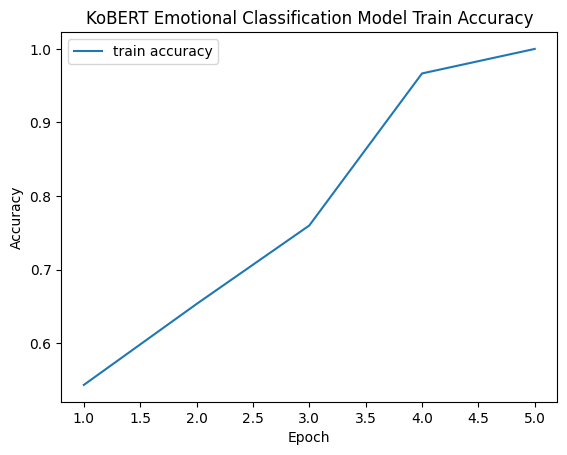

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,6),train_history,label='train accuracy',)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('KoBERT Emotional Classification Model Train Accuracy')
plt.show()

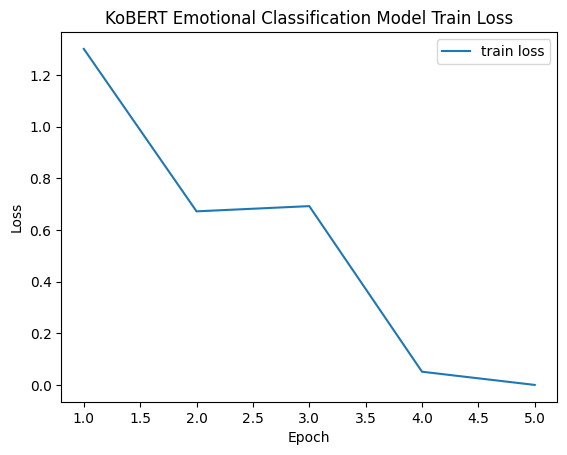

In [ ]:
plt.plot(np.arange(1,6),loss_history, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('KoBERT Emotional Classification Model Train Loss')
plt.show()

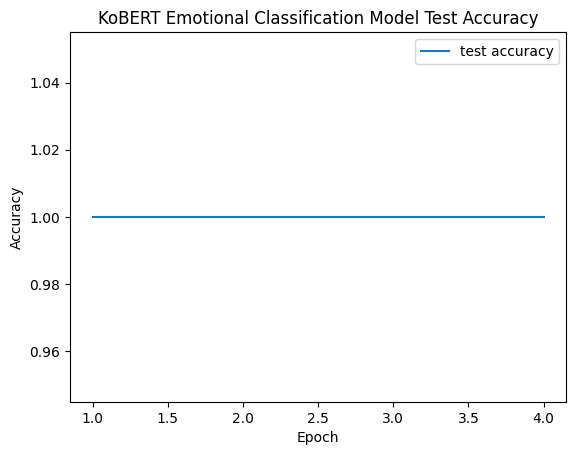

In [ ]:
plt.plot(np.arange(1,5),test_history, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('KoBERT Emotional Classification Model Test Accuracy')
plt.show()

In [ ]:
data_depressed.to_csv('data_train.csv')
data_depressed_val.to_csv('data_test.csv')